In [19]:
import os
import warnings

import pandas as pd

from joblib import load
from utils.plot import *
from utils.scaler import *
from sklearn.metrics import *
from scipy.stats import entropy
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

In [20]:
plt.rc('font', family='GULIM')
warnings.filterwarnings(action='ignore')
InteractiveShell.ast_node_interactivity = "all"

In [21]:
X_test = pd.read_csv('Database/test/X_self_test_norm.csv', index_col=0)
# X_test = pd.read_csv('Database/test/X_real_test_norm.csv', index_col=0)
y_test = pd.read_csv('Database/test/y_self_test.csv', index_col=0)

In [84]:
X_test.shape

(144897, 57)

# Best-model dict 저장

In [23]:
STN_list = ['STN001', 'STN002', 'STN003', 'STN004', 'STN005', 'STN006', 'STN007', 'STN008', 'STN009', 'STN010',
            'STN011', 'STN012', 'STN013', 'STN014', 'STN015', 'STN016', 'STN017', 'STN018', 'STN019', 'STN020']

GMM_list = [f'GMM{i}' for i in range(1)]

dt_files = sorted(filename for filename in os.listdir('File/DT') if filename.endswith('.pkl'))
lgb_files = sorted(filename for filename in os.listdir('File/LGBM') if filename.endswith('.pkl'))
# xgb_files = sorted(filename for filename in os.listdir('File/XGB') if filename.endswith('.pkl'))
# cat_files = sorted(filename for filename in os.listdir('File/CAT') if filename.endswith('.pkl'))

best_dt_dict = {}
best_lgb_dict = {}
# best_xgb_dict = {}
# best_cat_dict = {}

for i, STN in enumerate(GMM_list):
    best_dt_dict[STN] = load(os.path.join('File/DT', dt_files[i]))
    best_lgb_dict[STN] = load(os.path.join('File/LGBM', lgb_files[i]))
    # best_xgb_dict[STN] = load(os.path.join('File/XGB', xgb_files[i]))
    # best_cat_dict[STN] = load(os.path.join('File/CAT', cat_files[i]))

# 예측값 dict 저장

In [24]:
pred_dt_dict = {}
pred_lgb_dict = {}
# pred_xgb_dict = {}
# pred_cat_dict = {}

# 아무것도 안했을 때
for i, STN in enumerate(GMM_list):
    pred_dt_dict[STN] = pd.DataFrame(best_dt_dict[STN].predict_proba(X_test))
    pred_lgb_dict[STN] = pd.DataFrame(best_lgb_dict[STN].predict_proba(X_test))
    # pred_xgb_dict[STN] = pd.DataFrame(best_xgb_dict[STN].predict_proba(X_test))
    # pred_cat_dict[STN] = pd.DataFrame(best_cat_dict[STN].predict_proba(X_test))

# 60개 싱글모델 예측값 DataFrame 저장

In [28]:
# prediction_df = np.array()
# for i, STN in enumerate(GMM_list):
#     prediction_df = pd.concat(
#         [prediction_df,
#          pd.DataFrame(pred_dt_dict[STN].values),
#          pd.DataFrame(pred_lgb_dict[STN].values),
#          pd.DataFrame(pred_xgb_dict[STN].values, columns=[f'xgb_{STN}']),
#          pd.DataFrame(pred_cat_dict[STN].values, columns=[f'cat_{STN}'])
#          ], axis=1)

# prediction_df.index = X_test.index

In [38]:
prediction_list = []
for i, STN in enumerate(GMM_list):
         prediction_list.append(pred_dt_dict[STN].values)
         prediction_list.append(pred_lgb_dict[STN].values)
         predictions = np.array(prediction_list)

# 60개 싱글모델 metric DataFrame 저장

In [22]:
# metric_df = pd.DataFrame(columns=['R2', 'RMSE', 'MAE', 'MAPE'])
# for i, STN in enumerate(GMM_list):
#     metric_df = pd.concat(
#         [metric_df, pd.DataFrame([r2_score(y_test.values, pred_dt_dict[STN]),
#                                   root_mean_squared_error(y_test.values, pred_dt_dict[STN]),
#                                   mean_absolute_error(y_test.values, pred_dt_dict[STN]),
#                                   mean_absolute_percentage_error(y_test.values, pred_dt_dict[STN])],
#                                  index=metric_df.columns, columns=[f'DT_{STN}']).T], axis=0)
# 
#     metric_df = pd.concat(
#         [metric_df, pd.DataFrame([r2_score(y_test.values, pred_lgb_dict[STN]),
#                                   root_mean_squared_error(y_test.values, pred_lgb_dict[STN]),
#                                   mean_absolute_error(y_test.values, pred_lgb_dict[STN]),
#                                   mean_absolute_percentage_error(y_test.values, pred_lgb_dict[STN])],
#                                  index=metric_df.columns, columns=[f'LGB_{STN}']).T], axis=0)
# 
#     metric_df = pd.concat(
#         [metric_df, pd.DataFrame([r2_score(y_test.values, pred_xgb_dict[STN]),
#                                   root_mean_squared_error(y_test.values, pred_xgb_dict[STN]),
#                                   mean_absolute_error(y_test.values, pred_xgb_dict[STN]),
#                                   mean_absolute_percentage_error(y_test.values, pred_xgb_dict[STN])],
#                                  index=metric_df.columns, columns=[f'XGB_{STN}']).T], axis=0)
# 
#     metric_df = pd.concat(
#         [metric_df, pd.DataFrame([r2_score(y_test.values, pred_cat_dict[STN]),
#                                   root_mean_squared_error(y_test.values, pred_cat_dict[STN]),
#                                   mean_absolute_error(y_test.values, pred_cat_dict[STN]),
#                                   mean_absolute_percentage_error(y_test.values, pred_cat_dict[STN])],
#                                  index=metric_df.columns, columns=[f'CAT_{STN}']).T], axis=0)

# Entropy Fuzzy

In [77]:
def fuzzy_ensemble_predict(predictions):
    # 엔트로피 기반 가중치 계산
    entropies = np.array([entropy(pred.T) for pred in predictions])
    weights = 1 - entropies / np.max(entropies)
    weights = weights / np.sum(weights, axis=0)

    # 가중 평균 계산
    weighted_predictions = np.zeros((predictions.shape[1], predictions.shape[2]))

    # 가중치를 적용한 최종 예측 계산
    for i in range(predictions.shape[0]):
        weighted_predictions += weights[i, :, np.newaxis] * predictions[i]
    final_predictions = np.argmax(weighted_predictions, axis=1)
    return final_predictions

# 퍼지 앙상블로 예측
ensembled_pred = fuzzy_ensemble_predict(predictions)

In [80]:
ensembled_pred_df=pd.DataFrame(ensembled_pred, index= y_test.index)

# CSI 계산

In [83]:
data = pd.concat([ensembled_pred_df, y_test], axis=1)

mapping = {
    0: "<0.1",
    1: "0.1<=X<0.2",
    2: "0.2<=X<0.5",
    3: "0.5<=X<1",
    4: "1<=X<2",
    5: "2<=X<5",
    6: "5<=X<10",
    7: "10<=X<20",
    8: "20<=X<30",
    9: "X>=30"
}

data['predicted'] = data.iloc[:, 0].map(mapping)
data['observed'] = data.iloc[:, 1].map(mapping)

csi_categories = ["<0.1", "0.1<=X<0.2", "0.2<=X<0.5", "0.5<=X<1", "1<=X<2", "2<=X<5", "5<=X<10", "10<=X<20", "20<=X<30",
                  "X>=30"]
csi_table = pd.DataFrame(0, index=csi_categories, columns=csi_categories)

for index, row in data.iterrows():
    observed = row['observed']
    predicted = row['predicted']
    csi_table.at[observed, predicted] += 1

cal_CSI(csi_table)

0.03322226090416273

# Real-test prediction 저장

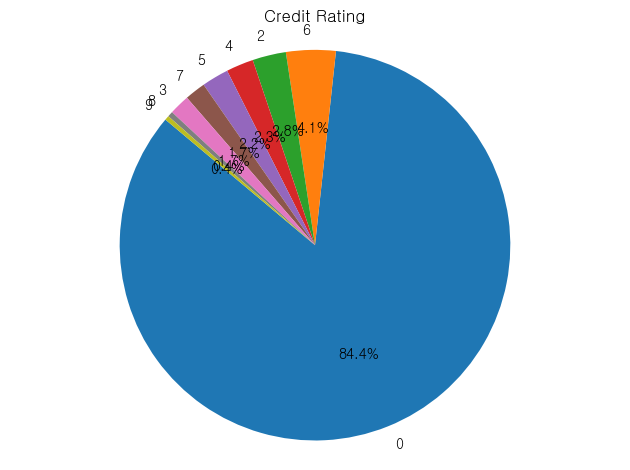

In [752]:
pred_rating_df2 = prediction_df.applymap(lambda x: map_values(x))
plot_imabalance(pred_rating_df2, 'lgb_GMM14')

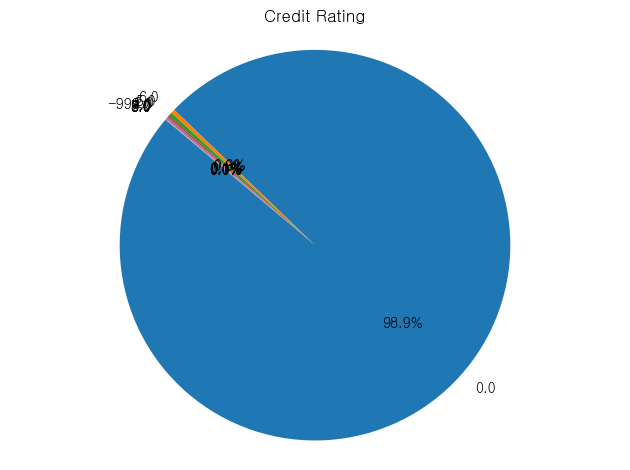

In [84]:
submssion_df = pd.read_csv('Database/rainfall_test.csv')
submssion_df.loc[pred_rating_df.index, 'rainfall_test.class_interval'] = pred_rating_df['Prediction']
plot_imabalance(submssion_df, 'rainfall_test.class_interval')

In [545]:
submssion_df.to_csv('File/240105.csv', index=False)